## Capital Center Temperature Time Series Prediction

In [1]:
# Importing libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# To Display all the csv columns
pd.set_option('display.max_columns', 500)

In [2]:
# visualizing the data
data = pd.read_csv('temperature.csv')
data.head(10)

,id,date,venue,temperature,precipitation
0,21700001,2017-10-17,Quicken Loans Arena,53.51,0.0000
1,21700002,2017-10-17,Oracle Arena,81.79,0.0000
2,21700003,2017-10-18,Little Caesars Arena,67.30,0.0000
3,21700004,2017-10-18,Bankers Life Fieldhouse,65.36,0.0000
4,21700005,2017-10-18,Amway Center,75.14,0.0005
5,21700006,2017-10-18,Capital Center,58.99,0.0000
6,21700007,2017-10-18,Td Garden,53.44,0.0000
7,21700008,2017-10-18,Fedex Forum,69.94,0.0000
8,21700009,2017-10-18,American Airlines Center,75.73,0.0000
9,21700010,2017-10-18,Vivint Smart Home Arena,70.78,0.0000


## Data Transformation

In [3]:
# You can run this function to transform the entire dataset at once or run the individual cells 
# below to see what's happening at each step. If you run this function, skip the remaining cell and 
# go directly to "Splitting Data" section

def transform_data(csv_filename):
    '''Takes as an input a casv file as provided in the original data 
    and transforms it so it can be fed into the neural network with
    no. of rows = no. of day and 56 feature columns'''
    data = pd.read_csv(csv_filename)
    # scaling the temperature and precipitation data
    from sklearn.preprocessing import MinMaxScaler
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['temperature', 'precipitation']
    features_scaled = pd.DataFrame(data = data)
    features_scaled[numerical] = scaler.fit_transform(data[numerical])
#     print('Scaled Data:',features_scaled.head())
    
    # Changing dates to no of days from first day
    date_format = "%Y-%m-%d"
    first_date = datetime(2017, 7, 1, 0, 0) 
    day_list = []
    month_list = []
    # To loop through every date and find how far it is from first day
    data = features_scaled
    for date in data['date']:
        b = datetime.strptime(str(date), date_format)# converting to datetime format
        difference = b-first_date
        day_list.append(difference.days)
        month_list.append(b.month)

    # Appending new column to dataframe
    data['day'] = day_list
    data['month'] = month_list
    
    # Sorting values by date
    data = data.sort_values(by=['day'])
    # Create a list going from day 0 to day 571 (no. of days in the data) to create new data frame
    days_list = []
    for i in range(572):
        days_list.append(i)
    # Setting the type of the dataframe to be float32 which is required for neural network
    new_df = pd.DataFrame(data={'day':days_list},dtype='float32')
    venues_list = data['venue'].unique()

    # Naming all the categories for new dataframe
    category_list = []
    for venue in venues_list:
        temp_list = venue.lower().split()
        txt = ""
        for item in temp_list:
            txt += item+"_"
        txt+='temperature'
        category_list.append(txt)
    for venue in venues_list:
        temp_list = venue.lower().split()
        txt = ""
        for item in temp_list:
            txt += item+"_"
        txt+='precipitation'
        category_list.append(txt)

    # creating a list with all values -1
    missing_val_list = np.full((572),-1,dtype='float32')
    # Putting all categories in the new data frame
    for cat in category_list:
        new_df[cat]=missing_val_list
    
    # Updating temperature values of all categories
    for day in data['day']:
        temp_df = data[data['day']==day]
        for val in temp_df['venue']:
            venue = val
            temp_list = val.lower().split()
            category = ""
            for item in temp_list:
                category += item+"_"
            category+='temperature'
            num = (temp_df[temp_df['venue']==venue]['temperature']).unique()[0]
            new_df[category][day] = num

    # Updating precipitation values of all categories
    for day in data['day']:
        temp_df = data[data['day']==day]
        for val in temp_df['venue']:
            venue = val
            temp_list = val.lower().split()
            category = ""
            for item in temp_list:
                category += item+"_"
            category+='precipitation'
            num = (temp_df[temp_df['venue']==venue]['precipitation']).unique()[0]
            new_df[category][day] = num
            
    # Adding a target column by shifting Capital Center Temperature values up by one
    target_list = np.full((572),-1,dtype='float32')
    for i in range(len(new_df['capital_center_temperature'])):
        try:
            target_list[i] = new_df['capital_center_temperature'][i+1]
        except:
            pass
    new_df['target'] = target_list
    
    # checking for NA values and filling them with -1
    new_df = new_df.fillna(-1.0)

    # Creating a dataframe with no NA values in the target columns (Capital Center Temperature)
    final_df = new_df[round(new_df['target'])!=-1]
    
    return final_df



In [4]:
# Getting the dataset to be fed into neural network
# This can take upto 30 seconds
final_df = transform_data('temperature.csv')
final_df.head()

,day,american_airlines_center_temperature,little_caesars_arena_temperature,bankers_life_fieldhouse_temperature,spectrum_center_temperature,chesapeake_energy_arena_temperature,vivint_smart_home_arena_temperature,wells_fargo_arena_temperature,madison_square_garden_temperature,at&t_center_temperature,amway_center_temperature,staples_center_temperature,pepsi_center_temperature,golden_1_center_temperature,quicken_loans_arena_temperature,smoothie_king_center_temperature,state_farm_arena_temperature,united_center_temperature,target_center_temperature,oracle_arena_temperature,fedex_forum_temperature,barclays_center_temperature,td_garden_temperature,fiserv_forum_temperature,capital_center_temperature,talking_stick_resort_arena_temperature,scotiabank_arena_temperature,moda_center_temperature,toyota_center_temperature,american_airlines_center_precipitation,little_caesars_arena_precipitation,bankers_life_fieldhouse_precipitation,spectrum_center_precipitation,chesapeake_energy_arena_precipitation,vivint_smart_home_arena_precipitation,wells_fargo_arena_precipitation,madison_square_garden_precipitation,at&t_center_precipitation,amway_center_precipitation,staples_center_precipitation,pepsi_center_precipitation,golden_1_center_precipitation,quicken_loans_arena_precipitation,smoothie_king_center_precipitation,state_farm_arena_precipitation,united_center_precipitation,target_center_precipitation,oracle_arena_precipitation,fedex_forum_precipitation,barclays_center_precipitation,td_garden_precipitation,fiserv_forum_precipitation,capital_center_precipitation,talking_stick_resort_arena_precipitation,scotiabank_arena_precipitation,moda_center_precipitation,toyota_center_precipitation,target
8,8.0,0.770452,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,0.861369,-1.0,0.868806,0.732097,0.925378,-1.000000,0.752987,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.745550,0.705858,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.215564,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.012062,0.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.007004,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.752486
9,9.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.886856,0.711289,0.751233,-1.0,0.759505,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.748057,0.752486,0.952453,0.714298,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.0,0.0,0.001167,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,0.792513
108,108.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.503384,-1.000000,-1.0,-1.000000,-1.0,0.739701,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0.0,-1.000000,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.549177
110,110.0,-1.000000,-1.0,-1.000000,-1.0,0.718476,-1.0,-1.0,-1.0,-1.000000,-1.0,0.763182,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.607671,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.630066
122,122.0,-1.000000,-1.0,0.413972,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,0.621543,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.498454,-1.000000,0.391075,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.482076


### Individual steps to transform data (Ignore if you ran the above function)

In [108]:
# scaling the temperature and precipitation data
from sklearn.preprocessing import MinMaxScaler
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['temperature', 'precipitation']
features_scaled = pd.DataFrame(data = data)
features_scaled[numerical] = scaler.fit_transform(data[numerical])
features_scaled.head()

,id,date,venue,temperature,precipitation
0,21700001,2017-10-17,Quicken Loans Arena,0.503384,0.000000
1,21700002,2017-10-17,Oracle Arena,0.739701,0.000000
2,21700003,2017-10-18,Little Caesars Arena,0.618618,0.000000
3,21700004,2017-10-18,Bankers Life Fieldhouse,0.602407,0.000000
4,21700005,2017-10-18,Amway Center,0.684131,0.001946


In [109]:
# Changing dates to no of days from first day
date_format = "%Y-%m-%d"
first_date = datetime(2017, 7, 1, 0, 0) 
day_list = []
month_list = []
# To loop through every date and find how far it is from first day
data = features_scaled
for date in data['date']:
    b = datetime.strptime(str(date), date_format)# converting to datetime format
    difference = b-first_date
    day_list.append(difference.days)
    month_list.append(b.month)

# Appending new column to dataframe
data['day'] = day_list
data['month'] = month_list
data.head(10)

,id,date,venue,temperature,precipitation,day,month
0,21700001,2017-10-17,Quicken Loans Arena,0.503384,0.000000,108,10
1,21700002,2017-10-17,Oracle Arena,0.739701,0.000000,108,10
2,21700003,2017-10-18,Little Caesars Arena,0.618618,0.000000,109,10
3,21700004,2017-10-18,Bankers Life Fieldhouse,0.602407,0.000000,109,10
4,21700005,2017-10-18,Amway Center,0.684131,0.001946,109,10
5,21700006,2017-10-18,Capital Center,0.549177,0.000000,109,10
6,21700007,2017-10-18,Td Garden,0.502799,0.000000,109,10
7,21700008,2017-10-18,Fedex Forum,0.640679,0.000000,109,10
8,21700009,2017-10-18,American Airlines Center,0.689062,0.000000,109,10
9,21700010,2017-10-18,Vivint Smart Home Arena,0.647698,0.000000,109,10


In [110]:
# Sorting values by date
data = data.sort_values(by=['day'])
data.head()

,id,date,venue,temperature,precipitation,day,month
1951,1421700001,2017-07-01,American Airlines Center,0.851592,0.000000,0,7
1954,1421700004,2017-07-01,Little Caesars Arena,0.662321,0.295720,0,7
1952,1421700002,2017-07-01,Bankers Life Fieldhouse,0.656388,0.474319,0,7
1953,1421700003,2017-07-01,American Airlines Center,0.851592,0.000000,0,7
1957,1421700007,2017-07-02,Spectrum Center,0.693658,0.054086,1,7


In [111]:
# Getting temperature data for only the Capital Center
capital_center_data = data[data['venue']=='Capital Center']
capital_center_data.head()

,id,date,venue,temperature,precipitation,day,month
1994,1521700024,2017-07-10,Capital Center,0.752486,0.0,9,7
2003,1521700033,2017-07-11,Capital Center,0.792513,0.0,10,7
5,21700006,2017-10-18,Capital Center,0.549177,0.0,109,10
19,21700020,2017-10-20,Capital Center,0.630066,0.0,111,10
107,21700108,2017-11-01,Capital Center,0.482076,0.0,123,11


In [112]:
# Getting details on data from all places
places = data['venue'].unique()
print('Total Places:',len(data['venue'].unique()))
print('')
for place in places:
    Quicken_Loans_data = data[data['venue']==place]
    print(place,':',len(Quicken_Loans_data['id']))
# print(len(Quicken_Loans_data['id']))
# Quicken_Loans_data.head()

Total Places: 28

American Airlines Center : 148
Little Caesars Arena : 71
Bankers Life Fieldhouse : 71
Spectrum Center : 69
Chesapeake Energy Arena : 69
Vivint Smart Home Arena : 73
Wells Fargo Arena : 70
Madison Square Garden : 64
At&t Center : 74
Amway Center : 70
Staples Center : 146
Pepsi Center : 72
Golden 1 Center : 72
Quicken Loans Arena : 72
Smoothie King Center : 70
State Farm Arena : 68
United Center : 70
Target Center : 72
Oracle Arena : 70
Fedex Forum : 73
Barclays Center : 70
Td Garden : 71
Fiserv Forum : 72
Capital Center : 68
Talking Stick Resort Arena : 73
Scotiabank Arena : 70
Moda Center : 74
Toyota Center : 70


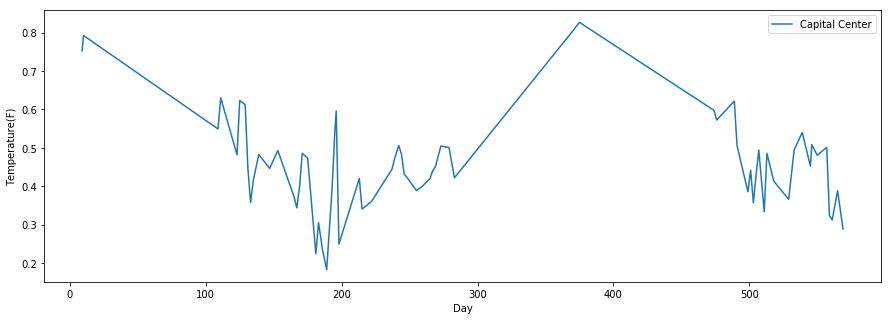

In [113]:
# Plotting temperature at Capital Center
plt.figure(figsize=(15,5))
plt.plot(capital_center_data['day'].values, capital_center_data['temperature'].values,label='Capital Center')
plt.xlabel('Day')
plt.ylabel('Temperature(F)')
plt.legend(loc='best')
plt.show()

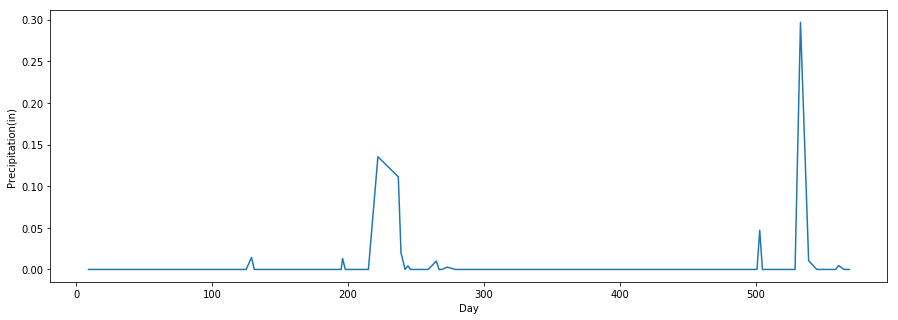

In [114]:
# Plotting precipitation values for capital center
plt.figure(figsize=(15,5))
plt.plot(capital_center_data['day'].values, capital_center_data['precipitation'].values,label='Capital Center')
plt.xlabel('Day')
plt.ylabel('Precipitation(in)')
plt.show()

In [115]:
# Create a list going from day 0 to day 571 (no. of days in the data) to create new data frame
days_list = []
for i in range(572):
    days_list.append(i)

# Setting the new dataframe as float32 and adding day columns
new_df = pd.DataFrame(data={'day':days_list},dtype='float32')
new_df.head()

,day
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0


In [116]:
venues_list = data['venue'].unique()

# Naming all the categories for new dataframe
category_list = []
for venue in venues_list:
    temp_list = venue.lower().split()
    txt = ""
    for item in temp_list:
        txt += item+"_"
    txt+='temperature'
    category_list.append(txt)
for venue in venues_list:
    temp_list = venue.lower().split()
    txt = ""
    for item in temp_list:
        txt += item+"_"
    txt+='precipitation'
    category_list.append(txt)

# creating a list with all values -1
missing_val_list = np.full((572),-1,dtype='float32')

In [117]:
# Putting all categories in the new data frame
for cat in category_list:
    new_df[cat]=missing_val_list
new_df.head()

,day,american_airlines_center_temperature,little_caesars_arena_temperature,bankers_life_fieldhouse_temperature,spectrum_center_temperature,chesapeake_energy_arena_temperature,vivint_smart_home_arena_temperature,wells_fargo_arena_temperature,madison_square_garden_temperature,at&t_center_temperature,amway_center_temperature,staples_center_temperature,pepsi_center_temperature,golden_1_center_temperature,quicken_loans_arena_temperature,smoothie_king_center_temperature,state_farm_arena_temperature,united_center_temperature,target_center_temperature,oracle_arena_temperature,fedex_forum_temperature,barclays_center_temperature,td_garden_temperature,fiserv_forum_temperature,capital_center_temperature,talking_stick_resort_arena_temperature,scotiabank_arena_temperature,moda_center_temperature,toyota_center_temperature,american_airlines_center_precipitation,little_caesars_arena_precipitation,bankers_life_fieldhouse_precipitation,spectrum_center_precipitation,chesapeake_energy_arena_precipitation,vivint_smart_home_arena_precipitation,wells_fargo_arena_precipitation,madison_square_garden_precipitation,at&t_center_precipitation,amway_center_precipitation,staples_center_precipitation,pepsi_center_precipitation,golden_1_center_precipitation,quicken_loans_arena_precipitation,smoothie_king_center_precipitation,state_farm_arena_precipitation,united_center_precipitation,target_center_precipitation,oracle_arena_precipitation,fedex_forum_precipitation,barclays_center_precipitation,td_garden_precipitation,fiserv_forum_precipitation,capital_center_precipitation,talking_stick_resort_arena_precipitation,scotiabank_arena_precipitation,moda_center_precipitation,toyota_center_precipitation
0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [118]:
# Updating temperature values of all categories
for day in data['day']:
    temp_df = data[data['day']==day]
    for val in temp_df['venue']:
        venue = val
        temp_list = val.lower().split()
        category = ""
        for item in temp_list:
            category += item+"_"
        category+='temperature'
        num = (temp_df[temp_df['venue']==venue]['temperature']).unique()[0]
        new_df[category][day] = num

# Updating precipitation values of all categories
for day in data['day']:
    temp_df = data[data['day']==day]
    for val in temp_df['venue']:
        venue = val
        temp_list = val.lower().split()
        category = ""
        for item in temp_list:
            category += item+"_"
        category+='precipitation'
        num = (temp_df[temp_df['venue']==venue]['precipitation']).unique()[0]
        new_df[category][day] = num

In [119]:
# The new created dataframe
new_df.head(10)

,day,american_airlines_center_temperature,little_caesars_arena_temperature,bankers_life_fieldhouse_temperature,spectrum_center_temperature,chesapeake_energy_arena_temperature,vivint_smart_home_arena_temperature,wells_fargo_arena_temperature,madison_square_garden_temperature,at&t_center_temperature,amway_center_temperature,staples_center_temperature,pepsi_center_temperature,golden_1_center_temperature,quicken_loans_arena_temperature,smoothie_king_center_temperature,state_farm_arena_temperature,united_center_temperature,target_center_temperature,oracle_arena_temperature,fedex_forum_temperature,barclays_center_temperature,td_garden_temperature,fiserv_forum_temperature,capital_center_temperature,talking_stick_resort_arena_temperature,scotiabank_arena_temperature,moda_center_temperature,toyota_center_temperature,american_airlines_center_precipitation,little_caesars_arena_precipitation,bankers_life_fieldhouse_precipitation,spectrum_center_precipitation,chesapeake_energy_arena_precipitation,vivint_smart_home_arena_precipitation,wells_fargo_arena_precipitation,madison_square_garden_precipitation,at&t_center_precipitation,amway_center_precipitation,staples_center_precipitation,pepsi_center_precipitation,golden_1_center_precipitation,quicken_loans_arena_precipitation,smoothie_king_center_precipitation,state_farm_arena_precipitation,united_center_precipitation,target_center_precipitation,oracle_arena_precipitation,fedex_forum_precipitation,barclays_center_precipitation,td_garden_precipitation,fiserv_forum_precipitation,capital_center_precipitation,talking_stick_resort_arena_precipitation,scotiabank_arena_precipitation,moda_center_precipitation,toyota_center_precipitation
0,0.0,0.851592,0.662321,0.656388,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.29572,0.474319,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,0.731846,0.749979,-1.000000,0.693658,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.00000,-1.000000,0.054086,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2.0,0.840896,-1.000000,-1.000000,-1.000000,0.758168,0.824183,0.958636,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,-1.00000,-1.000000,-1.000000,0.001167,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3.0,0.833793,0.722821,-1.000000,-1.000000,0.838974,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.000000,0.00000,-1.000000,-1.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4.0,-1.000000,0.726414,-1.000000,-1.000000,0.749645,0.866466,-1.000000,0.753907,0.872733,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,0.00000,-1.000000,-1.000000,0.000000,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,5.0,0.831370,-1.000000,0.759171,-1.000000,-1.00000

In [120]:
# Adding a target column by shifting Capital Center Temperature values up by one
target_list = np.full((572),-1,dtype='float32')
for i in range(len(new_df['capital_center_temperature'])):
    try:
        target_list[i] = new_df['capital_center_temperature'][i+1]
    except:
        pass
new_df['target'] = target_list
# Updated dataframe with taget column
new_df.head()

,day,american_airlines_center_temperature,little_caesars_arena_temperature,bankers_life_fieldhouse_temperature,spectrum_center_temperature,chesapeake_energy_arena_temperature,vivint_smart_home_arena_temperature,wells_fargo_arena_temperature,madison_square_garden_temperature,at&t_center_temperature,amway_center_temperature,staples_center_temperature,pepsi_center_temperature,golden_1_center_temperature,quicken_loans_arena_temperature,smoothie_king_center_temperature,state_farm_arena_temperature,united_center_temperature,target_center_temperature,oracle_arena_temperature,fedex_forum_temperature,barclays_center_temperature,td_garden_temperature,fiserv_forum_temperature,capital_center_temperature,talking_stick_resort_arena_temperature,scotiabank_arena_temperature,moda_center_temperature,toyota_center_temperature,american_airlines_center_precipitation,little_caesars_arena_precipitation,bankers_life_fieldhouse_precipitation,spectrum_center_precipitation,chesapeake_energy_arena_precipitation,vivint_smart_home_arena_precipitation,wells_fargo_arena_precipitation,madison_square_garden_precipitation,at&t_center_precipitation,amway_center_precipitation,staples_center_precipitation,pepsi_center_precipitation,golden_1_center_precipitation,quicken_loans_arena_precipitation,smoothie_king_center_precipitation,state_farm_arena_precipitation,united_center_precipitation,target_center_precipitation,oracle_arena_precipitation,fedex_forum_precipitation,barclays_center_precipitation,td_garden_precipitation,fiserv_forum_precipitation,capital_center_precipitation,talking_stick_resort_arena_precipitation,scotiabank_arena_precipitation,moda_center_precipitation,toyota_center_precipitation,target
0,0.0,0.851592,0.662321,0.656388,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.29572,0.474319,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,0.731846,0.749979,-1.000000,0.693658,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.00000,-1.000000,0.054086,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2.0,0.840896,-1.000000,-1.000000,-1.000000,0.758168,0.824183,0.958636,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.00000,-1.000000,-1.000000,0.001167,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3.0,0.833793,0.722821,-1.000000,-1.000000,0.838974,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.00000,-1.000000,-1.000000,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4.0,-1.000000,0.726414,-1.000000,-1.000000,0.749645,0.866466,-1.000000,0.753907,0.872733,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.00000,-1.000000,-1.000000,0.000000,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [121]:
# checking for NA values and filling them with -1
new_df = new_df.fillna(-1.0)

# Creating a dataframe with no NA values in the target columns (Capital Center Temperature)
final_df = new_df[round(new_df['target'])!=-1]
final_df.head()

,day,american_airlines_center_temperature,little_caesars_arena_temperature,bankers_life_fieldhouse_temperature,spectrum_center_temperature,chesapeake_energy_arena_temperature,vivint_smart_home_arena_temperature,wells_fargo_arena_temperature,madison_square_garden_temperature,at&t_center_temperature,amway_center_temperature,staples_center_temperature,pepsi_center_temperature,golden_1_center_temperature,quicken_loans_arena_temperature,smoothie_king_center_temperature,state_farm_arena_temperature,united_center_temperature,target_center_temperature,oracle_arena_temperature,fedex_forum_temperature,barclays_center_temperature,td_garden_temperature,fiserv_forum_temperature,capital_center_temperature,talking_stick_resort_arena_temperature,scotiabank_arena_temperature,moda_center_temperature,toyota_center_temperature,american_airlines_center_precipitation,little_caesars_arena_precipitation,bankers_life_fieldhouse_precipitation,spectrum_center_precipitation,chesapeake_energy_arena_precipitation,vivint_smart_home_arena_precipitation,wells_fargo_arena_precipitation,madison_square_garden_precipitation,at&t_center_precipitation,amway_center_precipitation,staples_center_precipitation,pepsi_center_precipitation,golden_1_center_precipitation,quicken_loans_arena_precipitation,smoothie_king_center_precipitation,state_farm_arena_precipitation,united_center_precipitation,target_center_precipitation,oracle_arena_precipitation,fedex_forum_precipitation,barclays_center_precipitation,td_garden_precipitation,fiserv_forum_precipitation,capital_center_precipitation,talking_stick_resort_arena_precipitation,scotiabank_arena_precipitation,moda_center_precipitation,toyota_center_precipitation,target
8,8.0,0.770452,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,0.861369,-1.0,0.868806,0.732097,0.925378,-1.000000,0.752987,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.745550,0.705858,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,0.215564,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.012062,0.0,-1.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.007004,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.752486
9,9.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.886856,0.711289,0.751233,-1.0,0.759505,-1.0,-1.000000,-1.0,-1.000000,-1.000000,0.748057,0.752486,0.952453,0.714298,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.0,0.0,0.001167,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,0.792513
108,108.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.503384,-1.000000,-1.0,-1.000000,-1.0,0.739701,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,0.0,-1.000000,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.549177
110,110.0,-1.000000,-1.0,-1.000000,-1.0,0.718476,-1.0,-1.0,-1.0,-1.000000,-1.0,0.763182,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.607671,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.630066
122,122.0,-1.000000,-1.0,0.413972,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,0.621543,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.498454,-1.000000,0.391075,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.482076


## Splitting Data into Train, Validation, Test Sets

In [5]:
# Split data into train (80%), test(10%) and validation(10%) sets
total_length = final_df.shape[0]
# new_df = new_df.drop('day',axis=1) #Dropping non-relevant column
values = final_df.values
train = values[:round(0.8*total_length), :]
val = values[round(0.8*total_length):round(1.1*0.8*total_length)+1, :]
test = values[round(1.1*0.8*total_length)+1:, :]

In [6]:
# Getting the indexes of train and test data to plot at the end
train_index = train[:,0]
test_index = test[:,0]

In [8]:
# split into input and outputs
train_X, train_y = train[:, 1:-1], train[:, -1]
val_X, val_y = val[:, 1:-1], val[:, -1]
test_X, test_y = test[:, 1:-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print('Training Data Shape:',train_X.shape, train_y.shape)
print('Validation Data Shape',val_X.shape, val_y.shape)
print('Test Data Shape',test_X.shape, test_y.shape)

Training Data Shape: (54, 1, 56) (54,)
Validation Data Shape (7, 1, 56) (7,)
Test Data Shape (7, 1, 56) (7,)


## Model Architecture

In [22]:
# design network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 512)            1165312   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 256)            787456    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 256)            525312    
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 256)               525312    
__________

## Training the Network

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint  

# To save model with best validation loss
checkpointer = ModelCheckpoint(filepath="weights.best.from_scratch.hdf5", 
                               verbose=1, save_best_only=True)
# fit network
history = model.fit(train_X, train_y,epochs=50,batch_size=10,validation_data=(val_X, val_y), verbose=1, callbacks=[checkpointer],shuffle=False)

Train on 54 samples, validate on 7 samples
Epoch 1/50
32/54 [================>.............] - ETA: 4s - loss: 0.2231
Epoch 00001: val_loss improved from inf to 0.16286, saving model to weights.best.from_scratch.hdf5
54/54 [==============================] - 12s 216ms/sample - loss: 0.2302 - val_loss: 0.1629
Epoch 2/50
32/54 [================>.............] - ETA: 0s - loss: 0.1840
Epoch 00002: val_loss improved from 0.16286 to 0.10391, saving model to weights.best.from_scratch.hdf5
54/54 [==============================] - 0s 7ms/sample - loss: 0.1866 - val_loss: 0.1039
Epoch 3/50
32/54 [================>.............] - ETA: 0s - loss: 0.1199
Epoch 00003: val_loss improved from 0.10391 to 0.02087, saving model to weights.best.from_scratch.hdf5
54/54 [==============================] - 1s 12ms/sample - loss: 0.1125 - val_loss: 0.0209
Epoch 4/50
32/54 [================>.............] - ETA: 0s - loss: 0.0337
Epoch 00004: val_loss did not improve from 0.02087
54/54 [=======================

Epoch 36/50
32/54 [================>.............] - ETA: 0s - loss: 0.0252
Epoch 00036: val_loss did not improve from 0.00403
54/54 [==============================] - 0s 4ms/sample - loss: 0.0189 - val_loss: 0.0054
Epoch 37/50
32/54 [================>.............] - ETA: 0s - loss: 0.0143
Epoch 00037: val_loss did not improve from 0.00403
54/54 [==============================] - 0s 3ms/sample - loss: 0.0149 - val_loss: 0.0051
Epoch 38/50
32/54 [================>.............] - ETA: 0s - loss: 0.0203
Epoch 00038: val_loss did not improve from 0.00403
54/54 [==============================] - 0s 3ms/sample - loss: 0.0172 - val_loss: 0.0050
Epoch 39/50
32/54 [================>.............] - ETA: 0s - loss: 0.0188
Epoch 00039: val_loss did not improve from 0.00403
54/54 [==============================] - 0s 3ms/sample - loss: 0.0175 - val_loss: 0.0060
Epoch 40/50
32/54 [================>.............] - ETA: 0s - loss: 0.0200
Epoch 00040: val_loss did not improve from 0.00403
54/54 [==

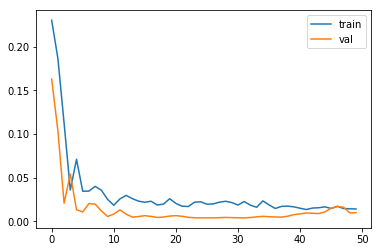

In [24]:
# Plotting train and validation loss
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Calculating Test Error

In [27]:
# Load the best weights
model.load_weights('weights.best.from_scratch.hdf5')

Root Mean Squared Value: 7.601034329188064


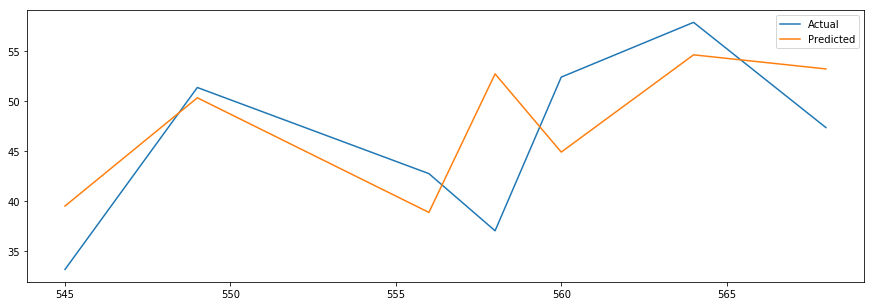

In [28]:
# Calculating the test error
preds = model.predict(val_X)
true = val_y

# Inverse transform the scaled values to get the real temperature values
max_temp = 112.94
min_temp = -6.73
max_prep = 0.257
min_prep = 0.0
new_preds = []
for i in range(len(preds)):
    new_preds.append((preds[i][0]*(max_temp-min_temp))+min_temp)
new_true = []
for i in range(len(true)):
    new_true.append((true[i]*(max_temp-min_temp))+min_temp)

# Calculating Root Mean squared error on test set
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(new_preds, new_true))
print("Root Mean Squared Value:",rmse)

plt.figure(figsize=(15,5))
plt.plot(test_index, new_true,label='Actual')
plt.plot(test_index, new_preds,label='Predicted')
plt.legend(loc='best')
plt.show()

## Model Predictions

In [123]:
# Model Prediction function to predict temperature of next day at capital center 
# based on temperature and precipitation at 28 sites on previous days

def predict_temperature(input_array,model):
    '''
    This function predict temperature value for next day at Capital Center
    The input to the function has to be an array of size 56 corresponding to both temperature(Fahrenheit) and 
    precipitation(Inches) values at 28 sites on previous day
    
    Input: 
    
    The input values for different sites should be in this order:
    
    ['american_airlines_center_temperature'
     'little_caesars_arena_temperature' 'bankers_life_fieldhouse_temperature'
     'spectrum_center_temperature' 'chesapeake_energy_arena_temperature'
     'vivint_smart_home_arena_temperature' 'wells_fargo_arena_temperature'
     'madison_square_garden_temperature' 'at&t_center_temperature'
     'amway_center_temperature' 'staples_center_temperature'
     'pepsi_center_temperature' 'golden_1_center_temperature'
     'quicken_loans_arena_temperature' 'smoothie_king_center_temperature'
     'state_farm_arena_temperature' 'united_center_temperature'
     'target_center_temperature' 'oracle_arena_temperature'
     'fedex_forum_temperature' 'barclays_center_temperature'
     'td_garden_temperature' 'fiserv_forum_temperature'
     'capital_center_temperature' 'talking_stick_resort_arena_temperature'
     'scotiabank_arena_temperature' 'moda_center_temperature'
     'toyota_center_temperature' 'american_airlines_center_precipitation'
     'little_caesars_arena_precipitation'
     'bankers_life_fieldhouse_precipitation' 'spectrum_center_precipitation'
     'chesapeake_energy_arena_precipitation'
     'vivint_smart_home_arena_precipitation' 'wells_fargo_arena_precipitation'
     'madison_square_garden_precipitation' 'at&t_center_precipitation'
     'amway_center_precipitation' 'staples_center_precipitation'
     'pepsi_center_precipitation' 'golden_1_center_precipitation'
     'quicken_loans_arena_precipitation' 'smoothie_king_center_precipitation'
     'state_farm_arena_precipitation' 'united_center_precipitation'
     'target_center_precipitation' 'oracle_arena_precipitation'
     'fedex_forum_precipitation' 'barclays_center_precipitation'
     'td_garden_precipitation' 'fiserv_forum_precipitation'
     'capital_center_precipitation' 'talking_stick_resort_arena_precipitation'
     'scotiabank_arena_precipitation' 'moda_center_precipitation'
     'toyota_center_precipitation']
     
    The second input is trained model
     
    Output:
    The function will return a temperature value in Fahrenheit for Capital Center
    
    '''
    
    # Scaling values as the model is training on scaled values
    max_temp = 112.94
    min_temp = -6.73
    max_prep = 0.257
    min_prep = 0.0
    new_array = np.full((len(input_array)),-1,dtype='float32')    
    
    # Scaling temperature values
    for i in range(len(input_array[:28])):
        if(round(input_array[i])!=-1.0):
            ms_val = (input_array[i]-min_temp)/(max_temp-min_temp)
            new_array[i] = ms_val
        else:
            new_array[i] = -1.0
        
    # Scaling precipitation values
    for i in range(28,len(input_array)):
        if(round(input_array[i])!=-1.0):
            ms_val = (input_array[i]-min_prep)/(max_prep-min_prep)
            new_array[i] = ms_val
        else:
            new_array[i] = -1.0
            
    # Reshaping the array to feed into the model
    new_array = new_array.reshape((1, 1, new_array.shape[0]))
    
    # Prediction
    pred_val = model.predict(new_array)[0][0]
    
    # Inverse transforming the predicted value to temperature in Fahrenheit
    max_temp = 112.94
    min_temp = -6.73
    prediction = (pred_val*(max_temp-min_temp))+min_temp
    
    return prediction
    

In [129]:
# Two test input arrays to test the predict function
test_array_1 = [72.09000126898289, -1.0, -1.0, -1.0, 64.10999740302563, -1.0, 63.11000219225883, -1.0, -1.0, -1.0, 59.319999301433555, -1.0, -1.0, 47.42999953895807, -1.0, -1.0, -1.0, -1.0, 58.12999822437763, -1.0, -1.0, -1.0, -1.0, -1.0, 63.310001234412184, 32.26999867498874, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.06560000237822533, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0]
test_array_2 = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 60.15000352919101, 12.079999432265758, 54.94999990165233, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 34.15999996602535, -1.0, -1.0, 36.97000113070011, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.032300001159310344, -1.0, -1.0, 0.06090000133216381, -1.0, -1.0]


print("Capital Center Predicted Temperature:")
print(predict_temperature(test_array_1,model), "degree Fahrenheit")

Capital Center Predicted Temperature:
42.55134677439928 degree Fahrenheit
